## Imports

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, PreTrainedTokenizer
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from datasets import load_dataset

## Config

In [4]:
torch.cuda.empty_cache()
torch.backends.cuda.max_split_size_mb = 10

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tokenizer and dataset

In [5]:
model_name = 't5-large'
tokenizer = T5Tokenizer.from_pretrained(model_name)
#t5_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [6]:
#dataset = pd.read_csv('/kaggle/input/dataset-summarization/summarization_dataset_final.csv')
dataset = pd.read_csv('/kaggle/input/data-final/summarization_data_final.csv')

In [7]:
df = pd.DataFrame(dataset)
df = df.loc[:, ["text", "summary"]]
df.head()

,text,summary
0,artificial intelligence is transforming the he...,ai is revolutionizing healthcare by improving ...
1,the future of transportation is electric with ...,evs are the future of transportation and as we...
2,remote work is here to stay and its changing t...,remote work is changing the way we balance wor...
3,blockchain technology is transforming the way ...,blockchain is transforming business by enablin...
4,the global food system is facing unprecedented...,building a sustainable and equitable food syst...


In [8]:
df['text'] = 'summarize: ' + df['text'].astype(str)

df.rename(columns = {'text':'source_text', 'summary':'target_text'}, inplace = True)
df.columns

Index(['source_text', 'target_text'], dtype='object')

In [9]:
df.head()

,source_text,target_text
0,summarize: artificial intelligence is transfor...,ai is revolutionizing healthcare by improving ...
1,summarize: the future of transportation is ele...,evs are the future of transportation and as we...
2,summarize: remote work is here to stay and its...,remote work is changing the way we balance wor...
3,summarize: blockchain technology is transformi...,blockchain is transforming business by enablin...
4,summarize: the global food system is facing un...,building a sustainable and equitable food syst...


In [10]:
df.shape

(1351, 2)

In [11]:
test_df = df.iloc[1201:, :]

In [12]:
df = df.iloc[:1201, :]

## Custom T5 Model
#### Defining custom T5 model with an additional layer

In [13]:
class CustomT5Model(nn.Module):
    def __init__(self, model_name):
        super(CustomT5Model, self).__init__()
        self.model_name = model_name
        print("model_name : "+self.model_name+"\n")
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        #Remove the last layer
        self.encoder_blocks = nn.ModuleList(self.model.encoder.block[:-1])
        #Additional layer added on top of the existing model
        self.linear = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.relu = nn.ReLU()
    
    def forward(self, input_ids, attention_mask, decoder_input_ids, decoder_attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask,
                             decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask)
        hidden_states = outputs.encoder_last_hidden_state
        new_hidden_states = self.linear(hidden_states)
        new_hidden_states = self.relu(new_hidden_states)
        outputs.encoder_last_hidden_state = new_hidden_states
        return outputs
    
    def generate_summary(self, input_text):
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        input_ids = input_ids.to(device)
        generated_ids = self.model.generate(input_ids=input_ids)
        generated_ids = generated_ids.to(device)
        summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return summary

## Custom PandasDataset
#### An instance of this class takes the pandas dataframe and returns some required tensors 

In [14]:
class PandasDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        source_max_token_len: int = 512,
        target_max_token_len: int = 128,
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        """ returns length of data """
        return len(self.data)

    def __getitem__(self, index: int):
        """ returns dictionary of input tensors to feed into T5 model"""

        data_row = self.data.iloc[index]
        source_text = data_row["source_text"]

        source_text_encoding = self.tokenizer(
            source_text,
            max_length=self.source_max_token_len,
            padding=True,
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        target_text_encoding = self.tokenizer(
            data_row["target_text"],
            max_length=self.target_max_token_len,
            padding=True,
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        labels = target_text_encoding["input_ids"]
        labels[
            labels == 0
        ] = -100  

        return dict(
            input_ids=torch.tensor(source_text_encoding["input_ids"].flatten()),
            attention_mask=torch.tensor(source_text_encoding["attention_mask"].flatten()),
            labels=labels.flatten(),
            decoder_input_ids = torch.tensor(target_text_encoding["input_ids"].flatten()),
            decoder_attention_mask=torch.tensor(target_text_encoding["attention_mask"].flatten())
        )

### Collate function for the data loader
#### Used for padding the sequences to the same length

In [15]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    target_ids = [item["labels"] for item in batch]
    decoder_input_ids = [item["decoder_input_ids"] for item in batch]
    decoder_attention_mask = [item["decoder_attention_mask"] for item in batch]

    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    target_ids = torch.nn.utils.rnn.pad_sequence(target_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    decoder_input_ids = torch.nn.utils.rnn.pad_sequence(decoder_input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    decoder_attention_mask = torch.nn.utils.rnn.pad_sequence(decoder_attention_mask, batch_first=True, padding_value=tokenizer.pad_token_id)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": target_ids, "decoder_input_ids": decoder_input_ids, "decoder_attention_mask": decoder_attention_mask}


## Train, Validation Split and Creating DataLoaders

In [16]:
# Create the training and validation datasets
train_df = df.sample(frac=0.75, random_state=45)
valid_df = df.drop(train_df.index)

# Convert the datasets to required format using the custom PandasDataset class
train_dataset = PandasDataset(train_df, tokenizer)
valid_dataset = PandasDataset(valid_df, tokenizer)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## Training

In [17]:
# Instatntiate the model
model = CustomT5Model(model_name)
model.to(device)

model_name : t5-large



CustomT5Model(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=1024, out_features=4096, bias=False)
                (wo): Line

In [18]:
# Defining the training arguments
training_args = {"num_train_epochs": 10, "learning_rate": 1e-5}

# Defining the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=training_args["learning_rate"])
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
validation_losses = []

for epoch in range(training_args["num_train_epochs"]):
    # Train the model on the training dataset
    model.train()

    for batch in train_loader:
        # Get the input and target summaries
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)
        target_ids = batch["labels"].to(device)
        decoder_input_ids = batch["decoder_input_ids"].to(device)

        # Compute the model's predictions
        outputs = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids, decoder_attention_mask = decoder_attention_mask)
            
        # Compute the loss between the predictions and the target summaries
        loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), decoder_input_ids.view(-1))
            
        # Backpropagate the loss and update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate the model on the validation dataset
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for batch in valid_loader:
            # Get the input and target summaries
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            decoder_input_ids = batch["decoder_input_ids"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)
            target_ids = batch["labels"].to(device)
            
            #outputs = model(input_ids, attention_mask=attention_mask, decoder_input_ids=target_ids[:, :-1], decoder_attention_mask = decoder_attention_mask)
            
            outputs = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids, decoder_attention_mask = decoder_attention_mask)
            
            loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), decoder_input_ids.view(-1))
            
            total_loss += loss.item()

    # Calculate the average validation loss and print the results
    avg_val_loss = total_loss / len(valid_loader)
    validation_losses.append(avg_val_loss)
    
    print("Epoch [{}/{}] : Validation Loss: {:.4f}".format(epoch+1, training_args["num_train_epochs"], avg_val_loss))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch [1/10] : Validation Loss: 4.5086
Epoch [2/10] : Validation Loss: 3.4192
Epoch [3/10] : Validation Loss: 2.8043
Epoch [4/10] : Validation Loss: 2.4507
Epoch [5/10] : Validation Loss: 2.0898
Epoch [6/10] : Validation Loss: 1.7755
Epoch [7/10] : Validation Loss: 1.5298
Epoch [8/10] : Validation Loss: 1.2650
Epoch [9/10] : Validation Loss: 1.0283
Epoch [10/10] : Validation Loss: 0.8356


In [20]:
validation_losses

[4.508616844813029,
 3.419220390319824,
 2.8042695776621502,
 2.4506647459665936,
 2.08981858253479,
 1.7754628149668377,
 1.5298491032918293,
 1.2649908725420633,
 1.0282689285278321,
 0.8355542341868083]

## Validation Loss vs Epoch Curve 

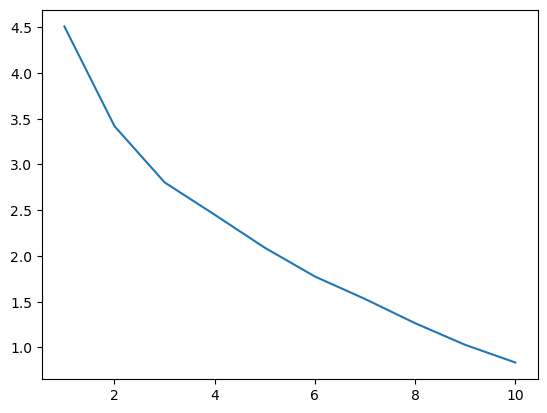

In [21]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(1, len(validation_losses)+1)], validation_losses)

In [22]:
torch.save(model.state_dict(), 'model-large.pt')

## Generating summaries from the finetuned model

In [23]:
model.load_state_dict(torch.load('model-large.pt'))

<All keys matched successfully>

In [34]:
input_text = "summarize: the covid-19 vaccine is approved, as appointments ramp up, you’ll be able to find a vaccine at pediatricians’ offices, pharmacies, and more"

output_text = model.generate_summary(input_text)

print("Original text :\n"+input_text)
print("\nGenerated Summary :\n"+output_text)

Original text :
summarize: the covid-19 vaccine is approved, as appointments ramp up, you’ll be able to find a vaccine at pediatricians’ offices, pharmacies, and more

Generated Summary :
the covid-19 vaccine is approved and will be available at pediatricians’ offices, pharmacies


In [25]:
!pip install rouge

In [26]:
from rouge import Rouge

# Initialize the ROUGE evaluator
rouge = Rouge()

# Calculate the ROUGE scores
scores = rouge.get_scores(input_text, output_text, avg=True)
print(scores)

{'rouge-1': {'r': 0.6428571428571429, 'p': 0.34615384615384615, 'f': 0.44999999545}, 'rouge-2': {'r': 0.5384615384615384, 'p': 0.2692307692307692, 'f': 0.35897435452991455}, 'rouge-l': {'r': 0.6428571428571429, 'p': 0.34615384615384615, 'f': 0.44999999545}}


In [27]:
generated_summaries = []
for document in test_df.iloc[:, 0]:
    generated_summaries.append(model.generate_summary(document))
    
target_summaries = []
for document in test_df.iloc[:, 1]:
    target_summaries.append(document)

In [28]:
from rouge import Rouge
rouge = Rouge()

In [29]:
rouge_scores = rouge.get_scores(target_summaries, generated_summaries, avg=True)

In [30]:
rouge_scores

{'rouge-1': {'r': 0.5550044008565681,
  'p': 0.37847219722200426,
  'f': 0.4403183742423761},
 'rouge-2': {'r': 0.3509954865396041,
  'p': 0.2325893004086752,
  'f': 0.27399666620121205},
 'rouge-l': {'r': 0.51639431758472,
  'p': 0.35146338068693916,
  'f': 0.4093048001974516}}

The best scores so far are shown below :

Number of epochs : 30
Learning Rate : 1e-6

{'rouge-1': {'r': 0.5589297466952267,
  'p': 0.40518956992855015,
  'f': 0.4611874515740227},
 'rouge-2': {'r': 0.37026811151811145,
  'p': 0.25087603810608,
  'f': 0.2935283646665617},
 'rouge-l': {'r': 0.5229177484881821,
  'p': 0.3779541726583791,
  'f': 0.4308589315342012}
}